# DSCI 552 Final Project - AR Model vs. LSTM on Time Series


In [54]:
import math
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.optimizers import *
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
import datetime as dt
from statsmodels.tsa.ar_model import AutoReg
import time
from sklearn.preprocessing import OneHotEncoder
from sklearn.inspection import permutation_importance
from math import sqrt
from statsmodels.tsa.stattools import adfuller

# fix random seed for reproducibility
np.random.seed(7)

In [55]:
bitcoin = pd.read_csv('BitCoin_Dataset.csv', index_col = "Day", parse_dates = True)
bitcoin.rename(columns={"BitCoin Price":"price"}, inplace = True)

In [14]:
bitcoin

,price
Day,
2018-01-01,13412.4400
2018-01-02,14740.7563
2018-01-03,15134.6513
2018-01-04,15155.2263
2018-01-05,16937.1738
...,...
2021-02-28,45256.4133
2021-03-01,49619.6433
2021-03-02,48502.8083


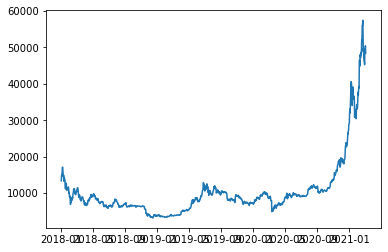

In [15]:
plt.plot(bitcoin['price'])


#### Data Preprocessing

In [16]:
#check for missing values
bitcoin.isnull().sum()

price    0
dtype: int64

Split the data to 80 percents as training data and 20 percents as test data

In [56]:
price = bitcoin.price.values
train_size = int(len(bitcoin) * 0.8)
test_size = len(bitcoin) - train_size
train_df, test_df = price[0:train_size], price[train_size:len(bitcoin)]

In [58]:
bitcoin[train_size:len(bitcoin)]

,price
Day,
2020-07-16,9116.3250
2020-07-17,9122.2200
2020-07-18,9140.2575
2020-07-19,9156.1100
2020-07-20,9185.3750
...,...
2021-02-28,45256.4133
2021-03-01,49619.6433
2021-03-02,48502.8083


## AR Model - Autoregression Model


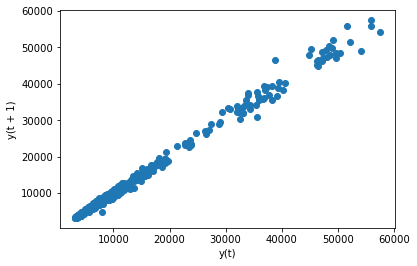

In [18]:
from pandas.plotting import lag_plot
lag_plot(bitcoin.price)
plt.show()

/Users/ws/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Test RMSE: 3094.015


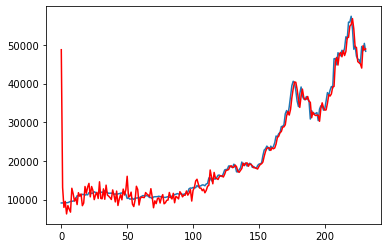

In [25]:

window = 120
model_ar = AutoReg(train_df, lags=window)
model_fit = model_ar.fit()
coef = model_fit.params

history_data = temp[len(temp)-window:]
history_data = [history_data[i] for i in range(len(history_data))]
predictions = list()
for t in range(len(test_df)):
    length = len(history_data)
    lag = [history_data[i] for i in range(length-window,length)]
    y = coef[0]
    for d in range(window):
        y += coef[d+1] * lag[window-d-1]
    obs = test_df[t]
    predictions.append(y)
    history_data.append(obs)


rmse = sqrt(mean_squared_error(test_df, predictions))
print('Test RMSE: %.3f' % rmse)
# plot
plt.plot(test_df)
plt.plot(predictions, color='red')
plt.show()

## Recurrent Neural Network

In [37]:
data = pd.read_csv('BitCoin_Dataset.csv', index_col = "Day", parse_dates = True)
data.rename(columns={"BitCoin Price":"price"}, inplace = True)

In [38]:
train_size = int(len(data) * 0.8)
test_size = len(data) - train_size
train_df, test_df = data[0:train_size], data[train_size:len(bitcoin)]

In [39]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [40]:
def create_dataset(x, y, time_steps = 1):
    x_data = []
    y_data = []
    for i in range(len(x) - time_steps):
        v = x.iloc[i: (i+time_steps)].to_numpy()
        x_data.append(v)
        y_data.append(y.iloc[i+time_steps])
    return np.array(x_data), np.array(y_data)

In [41]:

ts = 120
x_train, y_train = create_dataset(train_df, train_df.price, time_steps = ts)

x_test, y_test = create_dataset(test_df, test_df.price, time_steps = ts)

In [42]:
print (x_test.shape, y_test.shape)

(112, 120, 1) (112,)


In [43]:
print (x_train.shape, y_train.shape)

(807, 120, 1) (807,)


In [46]:
model = keras.Sequential()
model.add(keras.layers.Bidirectional(keras.layers.LSTM(units = 128, return_sequences=True, input_shape = (x_train.shape[1], x_train.shape[2]))))
model.add(keras.layers.Bidirectional(keras.layers.LSTM(units = 64, return_sequences=False)))
model.add(keras.layers.Dropout(rate = 0.1))
model.add(keras.layers.Dense(units=1))

In [47]:
model.compile(loss='mean_squared_error', optimizer='adam')


In [48]:
history = model.fit(x_train, y_train, epochs = 12, batch_size = 32, validation_split = 0.2, shuffle=False)


Epoch 1/12
21/21 [==============================] - 11s 243ms/step - loss: 0.1845 - val_loss: 0.1396
Epoch 2/12
21/21 [==============================] - 4s 173ms/step - loss: 0.2659 - val_loss: 0.0901
Epoch 3/12
21/21 [==============================] - 3s 160ms/step - loss: 0.0971 - val_loss: 0.1141
Epoch 4/12
21/21 [==============================] - 4s 169ms/step - loss: 0.0727 - val_loss: 0.1075
Epoch 5/12
21/21 [==============================] - 4s 168ms/step - loss: 0.0977 - val_loss: 0.0799
Epoch 6/12
21/21 [==============================] - 4s 173ms/step - loss: 0.0974 - val_loss: 0.1309
Epoch 7/12
21/21 [==============================] - 4s 174ms/step - loss: 0.1132 - val_loss: 0.0673
Epoch 8/12
21/21 [==============================] - 4s 173ms/step - loss: 0.0903 - val_loss: 0.0922
Epoch 9/12
21/21 [==============================] - 4s 174ms/step - loss: 0.0779 - val_loss: 0.0601
Epoch 10/12
21/21 [==============================] - 4s 185ms/step - loss: 0.0828 - val_loss: 0.083

In [49]:
y_pred = model.predict(x_test)


In [50]:
y_pred_inverse = y_pred * train_std.price + train_mean.price
y_test_inverse = y_test * train_std.price + train_mean.price

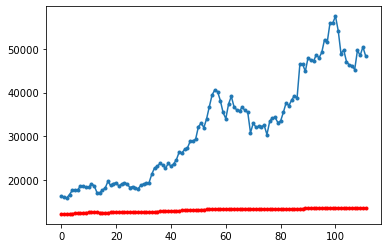

In [51]:
plt.plot(y_test_inverse.flatten(), marker='.', label='true')
plt.plot(y_pred_inverse.flatten(), 'r', marker='.', label='true')

In [52]:
model.evaluate(x_test, y_test)

4/4 [==============================] - 0s 48ms/step - loss: 86.5276


86.52764892578125

In [53]:

rmse = sqrt(mean_squared_error(y_pred_inverse, y_test_inverse))
rmse

21947.772351521293